# Dependencies

In [79]:
import numpy as np

# restore removed NumPy aliases so old code in networkx (and elsewhere) still works
if not hasattr(np, 'float_'):
    np.float_ = np.float64
if not hasattr(np, 'int'):
    np.int = int
import igraph as ig
import subprocess
from collections import defaultdict
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
from collections import Counter
import networkx as nx
import os
import csv
import tempfile
from pathlib import Path
import math, time, random
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

if len(sys.argv) < 2:
    print("Specify dataset: sms, fb_friends, CollegeMsg, CA-GrQc, facebook_combined, fb-pages-food, soc-hamsterster", flush=True)
    sys.exit(1)

dataArg = sys.argv[1]



# Common part

## Uniqueness

In [80]:
# Compuate equivalent class.
def ig_to_nauty(g):
    graph = "n " + str(g.vcount()) + "\n"
    graph += "g\n"
    for n in g.vs.indices:
        graph += str(n) + ":"
        for m in g.neighbors(n):
            graph += " " + str(m)
        graph += ";\n"
    
    return graph
def ig_to_dre(g):
    """
    Converts an igraph graph to the .dre format required by the anon binary.
    """
    lines = [f"!n={g.vcount()}"]
    for i in range(g.vcount()):
        neighbors = g.neighbors(i)
        end = '.' if i == g.vcount() - 1 else ';'
        lines.append(f"{i}: {' '.join(map(str, neighbors))}{end}")
    return '\n'.join(lines)

def computeEQ(G, criteria='nm'):
    '''
    Input: orignal graph
    Output: a dict of equivalent class and the list of nodes of the eqvialent class. i.e. {'class id': [nodes]}
    '''
    P = defaultdict(list)
    if criteria == 'dk':
        # 1) write the graph in .dre format to a temp file
        dre_text = ig_to_dre(G)
        tf = tempfile.NamedTemporaryFile(mode='w', suffix='.dre', delete=False)
        tf.write(dre_text)
        tf.flush()
        tf.close()
        try:
            # 2) locate the anon binary (adjust if your structure differs)
            project_root = Path.cwd().parent    # if cwd is …/dkAnonymity/nauty27r4
            anon_bin = project_root / "bin" / "anon"

            # 3) run: ./bin/anon <temp.dre> -d 1 -eq -s 0
            proc = subprocess.Popen(
                [str(anon_bin), tf.name, "-d", "3", "-eq", "-s", "0"],
                stdout=subprocess.PIPE, stderr=subprocess.PIPE
            )
            out, err = proc.communicate()
            res = out.decode()

            # 4) parse the equivalence classes
            lines = res.splitlines()
            # find the block
            try:
                start = lines.index("Start equivalence classes.") + 1
                end   = lines.index("End equivalence classes.")
                eq_lines = lines[start:end]
            except ValueError:
                # fallback: any line of pure integers
                eq_lines = [l for l in lines if l.strip() and all(tok.isdigit() for tok in l.split())]

            for line in eq_lines:
                members = list(map(int, line.split()))
                # use a tuple key so distinct classes map correctly
                P[tuple(sorted(members))] = members

        finally:
            # remove the temporary file
            os.unlink(tf.name)
    
    elif criteria == 'nm':
        for node in G.vs.indices:
            neighborhood = G.neighbors(node)
            n = len(neighborhood) + 1
            neighborhood.append(node)
            sg = G.subgraph(neighborhood)
            m = sg.ecount()
            P[(n, m)].append(node)

    return P

In [81]:
def uniqueness(G, criteria):
    '''
    Input: original graph
    Output: a number of uniquendess, and a list of unique nodes
    '''
    u = 0
    n = G.vcount()
    p = computeEQ(G, criteria)
    unique_nodes = set()
    k = 2
    for cl in p:
        # print(cl, p[cl])
        if len(p[cl]) < k:
            unique_nodes.update(p[cl])
    u = len(unique_nodes) / n
    return u, unique_nodes

## Initialization

In [82]:
G_origin = nx.Graph()
dataArg = 'fb_friends'  # default dataset
document=dataArg  # specify the dataset you want to use
if(dataArg != 'sms' and dataArg != 'fb_friends' and dataArg != 'CollegeMsg' and dataArg != 'CA-GrQc' and dataArg != 'facebook_combined' and dataArg != 'fb-pages-food' and dataArg != 'soc-hamsterster'):
    print("Invalid dataset specified. Please choose from: sms, fb_friends, CollegeMsg, CA-GrQc, facebook_combined, fb-pages-food, soc-hamsterster", flush=True)
    sys.exit(1)
# edges = [
#     (1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 5),
#     (4, 6), (6, 7), (6, 8), (7, 9), (8, 9), (8, 10), (9, 10)
# ] this is the original example
# G_origin.add_edges_from(edges)
# read data

# copenet-sms
with open('./datasets/sms.csv', newline='') as f:
    lines = csv.reader(f, delimiter=',')
    if document == 'sms':
        for line in lines:
            G_origin.add_edge(line[1], line[2])
# copenet-fb
with open('./datasets/fb_friends.csv', newline='') as f:
    lines = csv.reader(f, delimiter=',')
    if document == 'fb_friends':
        for line in lines:
            G_origin.add_edge(line[0], line[1])

# CollegeMsg
with open('./datasets/CollegeMsg.txt') as f:
        if document == 'CollegeMsg':
            for line in f:
                edge = line.strip().split(' ')
                G_origin.add_edge(edge[0], edge[1])
# ca-grqc        
with open('./datasets/CA-GrQc.txt') as f:
        if document == 'CA-GrQc':
            for line in f:
                edge = line.strip().split('\t')
                G_origin.add_edge(edge[0], edge[1])

# ego-fb
with open('./datasets/facebook_combined.txt') as f:
        if document == 'facebook_combined':
            for line in f:
                edge = line.strip().split(' ')
                G_origin.add_edge(edge[0], edge[1])
# fb-pages-food
with open('./datasets/fb-pages-food.txt', newline='') as f:
    if document == 'fb-pages-food':
        reader = csv.reader(f, delimiter=',')
        for line in reader:
            node1, node2 = int(line[0]), int(line[1])
            G_origin.add_edge(node1, node2)
# CollegeMsg
with open('./datasets/soc-hamsterster.txt') as f:
        if document == 'soc-hamsterster':
            for line in f:
                edge = line.strip().split(' ')
                G_origin.add_edge(edge[0], edge[1])          
        
G_origin = ig.Graph.from_networkx(G_origin)
criteria = 'nm'
U, unodes_origin = uniqueness(G_origin, criteria)
print("Uniqueness:", U, flush=True)

# info of empirical network
ig.summary(G_origin)

print("ACC:", G_origin.transitivity_avglocal_undirected(mode="zero"), 
"Transitivity:", G_origin.transitivity_undirected(), flush=True)
print("U_nm:", U, flush=True)
E0 = set(G_origin.get_edgelist())  # all possible edges in the original graph


Uniqueness: 0.4725
IGRAPH U--- 800 6429 -- 
+ attr: _nx_name (v)
ACC: 0.3153509697401216 Transitivity: 0.24430902767456378
U_nm: 0.4725


## Set the STEP

In [83]:
if(document == 'sms'):
    STEP = 6
if( document == 'fb_friends' or document == 'fb-pages-food'):
    STEP = 10
if(document == 'CollegeMsg' or document == 'CA-GrQc' or document == 'soc-hamsterster'):
    STEP = 25
if(document == 'facebook_combined'):
    STEP = 150
print("STEP:", STEP, flush=True)
CALCULATE_TIME = G_origin.ecount() // STEP

x = list(range(STEP, (CALCULATE_TIME+1)*STEP, STEP))
u_of_10 = np.full((10, CALCULATE_TIME+1), U)

STEP: 10


In [84]:
# Find all edges between unique nodes.
def getEdgeListUnique(G, node_list):
    '''
    Input: original graph, and list of unique nodes
    Output: list of edges between unique nodes
    '''
    edges = G.get_edgelist()
    res = []
    for edge in edges:
        if (edge[0] in node_list) and (edge[1] in node_list):
            res.append(edge)
    
    return res

## U/A

In [85]:
# Compute the U and A of all edges.
def edgeUA(G, unodes):
    '''
    Input: original graph, and list of unique nodes
    Output: U, A, and directly connected unique nodes
    '''
    edges = G.get_edgelist()
    res = {}
    for u, v in edges:
        f = []
        node_list = [u, v]
        neighbors_u = set(G.neighbors(u))
        neighbors_v = set(G.neighbors(v))
        node_list += list(neighbors_u.intersection(neighbors_v))
        for node in node_list:
            if node in unodes:
                f.append(1)
            else:
                f.append(0)
        res[u,v] = (sum(f), len(f)-sum(f), f[0]+f[1])

    return res

In [86]:
# Delete edges based on U/A
def deleteUA(G, num, ua):
    '''
    Input:
        G: original graph
        num: number of edges need to be deleted
        ua: U, A, number of directly connected unique nodes
    Output: modified graph
    '''
    p = []
    edges = []
    edge_candidates = G.get_edgelist()
    for j in edge_candidates:
        p.append((ua[j][0]+0.01)/(ua[j][1]+0.01))
    for _ in range(num):
        edge = random.choices(edge_candidates, weights=tuple(p))[0]
        index = edge_candidates.index(edge)
        edges.append(G.get_eid(edge[0], edge[1]))
        p[index] = 0

    G.delete_edges(edges)

    return G

In [87]:
def UA1Round(G, U, edge_vec, STEP, CALCULATE_TIME, criteria):
    u_ua = [U]
    
    t0 = time.time()
    for i in range(CALCULATE_TIME):
        # delete-U/A
        G = deleteUA(G, STEP, edge_vec)
        new_u_ua, unodes_ua = uniqueness(G, criteria)
        u_ua.append(new_u_ua)
        edge_vec = edgeUA(G, unodes_ua)
    #     print("u_ua:", new_u_ua)
    t1 = time.time()
    
    return u_ua, t1-t0, G

## Logistics Regression

In [88]:
# Transfer effect of uniqueness to label.
def value2label(x):
    if x>=0:
        return 0
    else:
        return 1

In [89]:
# Delete edges based on Logistic Regression Classification.
def LRDelete(G, num, model, unodes):
    '''
    Input:
        G: original graph
        num: the number of edges need to be deleted
        model: the trained classifier
        unodes: list of unique nodes
    Output: modified graph
    '''
    edges = G.get_edgelist()
    edge_vector = edgeUA(G, unodes)
    n = G.vcount()
    m = G.ecount()
    df = pd.DataFrame(columns=['N_nodes', 'N_edges', 'max', 'min', 'U', 'A', 'direct_connected_nodes', 'triangles'])
    for e in edges:
        df.loc[G.get_eid(e[0], e[1]), :] = [n, m, max(G.degree(e[0]), G.degree(e[1])), min(G.degree(e[0]), G.degree(e[1])), 
                                edge_vector[e][0], edge_vector[e][1], edge_vector[e][2], edge_vector[e][0]+edge_vector[e][1]-2]
    p = model.predict_proba(df)
    p = p[:,1]
    index = np.argsort(p)[-num:]
    G.delete_edges([G.get_eid(edges[i][0], edges[i][1]) for i in index])
    
    return G

In [90]:
# train LR model
train = pd.read_csv('./datasets/training_data.csv', index_col=0)
train['eff'] = train['eff'].apply(lambda x: value2label(x))
classifier = LogisticRegression(penalty='l1', solver='liblinear')
classifier.fit(train.iloc[:, :8], train.iloc[:, 8])
print(classifier.score(train.iloc[:, :8], train.iloc[:, 8]))
print("Coef:", classifier.coef_[0])

0.9014892239385811
Coef: [ 7.93233723e-04 -3.18432353e-04 -3.42245172e-02 -1.79186034e-01
  1.13046246e-02 -1.70293087e-02  1.86542970e+00  1.18421140e-01]


P-value for LR.

In [91]:
def logit_pvalue(model, x):
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p
print(logit_pvalue(classifier, train.iloc[:, :8]))

[nan  0.  0.  0.  0. nan nan  0. nan]


C:\Users\arsen\AppData\Local\Temp\ipykernel_12880\1386178148.py:11: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))


In [92]:
def LR1Round(G, U, unodes_origin, STEP, CALCULATE_TIME, criteria):
    u_lr = [U]
    unodes = unodes_origin.copy()
    t0 = time.time()

    for i in range(CALCULATE_TIME):
        # delete-LR
        G = LRDelete(G, STEP, classifier, unodes)
        # update info of delete-ua
        new_u_lr, unodes = uniqueness(G, criteria)
        u_lr.append(new_u_lr)
    #     print("u_lr:", new_u_lr)
    t1 = time.time()
    
    return u_lr, t1-t0, G

## Greedy

In [93]:
def getNodeVector(G):
    res = {}
    for node in G.vs.indices:
        neighborhood = G.neighbors(node)
        neighborhood.append(node)
        sg = G.subgraph(neighborhood)    # ego network
        res[node] = [len(neighborhood), sg.ecount()]
    
    return res

def delEdgeEff(G, edge, node_vec):
    eff = 0
    common_neighbors = set(G.neighbors(edge[0])).intersection(set(G.neighbors(edge[1])))
    P = Counter([tuple(node_vec[i]) for i in node_vec])
    
    for node in common_neighbors:    # indirectly related nodes
        n, m = tuple(node_vec[node])
        P[(n,m)] -= 1
        if P[(n,m)] == 1: eff -= 1
        elif P[(n,m)] == 0: eff += 1
        m -= 1
        if (n, m) not in P: eff -= 1
        elif P[(n,m)] == 1: eff += 1
        P[(n,m)] += 1

    # directly related nodes
    n, m = tuple(node_vec[edge[0]])
    P[(n,m)] -= 1
    if P[(n,m)] == 1: eff -= 1
    elif P[(n,m)] == 0: eff += 1

    n -= 1
    m -= len(common_neighbors)+1
    if (n, m) not in P: eff -= 1
    elif P[(n,m)] == 1: eff += 1
    P[(n,m)] += 1
    
    n, m = tuple(node_vec[edge[1]])
    P[tuple(node_vec[edge[1]])] -= 1
    if P[(n,m)] == 1: eff -= 1
    elif P[(n,m)] == 0: eff += 1
    
    n -= 1
    m -= len(common_neighbors)+1
    if (n, m) not in P: eff -= 1
    elif P[(n,m)] == 1: eff += 1
    P[(n,m)] += 1

    return eff

In [94]:
def greedyDelete(G, num, node_vec=None):
    edges = G.get_edgelist()
    if not node_vec:
        node_vec = getNodeVector(G)
    values = []
    
    for edge in edges:
        values.append(delEdgeEff(G, edge, node_vec))
    sorted_edges = sorted([i for i in enumerate(values)], key=lambda x: x[1])[-num:]
    G.delete_edges([G.get_eid(edges[i[0]][0], edges[i[0]][1]) for i in sorted_edges])
    
    return G

In [95]:
def greedy1Round(G, U, STEP, CALCULATE_TIME, criteria):
    u = [U]
    t_u = t_d = 0
    t0 = time.time()
    for i in range(CALCULATE_TIME):
        G = greedyDelete(G, STEP)
        new_u, _ = uniqueness(G, criteria)
        u.append(new_u)
    t1 = time.time()
    
    return u, t1-t0

### Original Simulated Annealing method 
##### This SA method recalculates uniquness at every iteration, which is computationally expensive. It is slower and it is only used for d-k-anonymity.

In [96]:

def build_graph_from_edges(G_template, edge_set):
    G = G_template.copy()
    G.delete_edges(G.es.indices)  # remove all
    G.add_edges(list(edge_set))
    return G
def simulatedAnnealing_original(G_template, E0, U_origin, step, time_budget, criteria, T0, alpha, budget, noise_std=0.01):
    total_edges = len(E0)
    scaling = 1.5
    max_removable = int(budget / 100 * total_edges)
    current_edges = set(E0)
    removed_edges = set()
    G = build_graph_from_edges(G_template, current_edges)
    current_u, _ = uniqueness(G, criteria)
    best_u = current_u
    best_edges = current_edges.copy()
    u_progress = [current_u]
    iteration = 0
    t_start = time.time()
    for outer in range(time_budget):
        for _ in range(step):
            iteration += 1
            edge = random.choice(list(E0))
            proposed_edges = current_edges.copy()
            proposed_removed = removed_edges.copy()
            if edge in proposed_edges:
                if len(proposed_removed) >= max_removable:
                    continue
                proposed_edges.remove(edge)
                proposed_removed.add(edge)
            else:
                proposed_edges.add(edge)
                proposed_removed.remove(edge)
            candidate_G = build_graph_from_edges(G_template, proposed_edges)
            candidate_u, _ = uniqueness(candidate_G, criteria)
            Δu = candidate_u - current_u
            noisy_Δu = Δu + random.gauss(0, noise_std)
            T = max(T0 * alpha ** (iteration + 1), 1e-8)
            accept = noisy_Δu < 0 
            if accept:
                current_edges = proposed_edges
                removed_edges = proposed_removed
                current_u = candidate_u
                G = candidate_G
                if candidate_u < best_u:
                    best_u = candidate_u
                    best_edges = current_edges.copy()
                elif candidate_u == best_u and len(current_edges) > len(best_edges):
                    best_edges = current_edges.copy()
        u_progress.append(current_u)
    t_end = time.time()
    final_G = build_graph_from_edges(G_template, best_edges)
    return final_G, u_progress, t_end - t_start, best_u, best_edges


### Simulated Annealing with incremental update
#### This method is used for (n,m)-anonymity only.

In [97]:
def compute_nm_class(G, node):
    neighborhood = G.neighbors(node)
    n = len(neighborhood) + 1
    sub_nodes = neighborhood + [node]
    sg = G.subgraph(sub_nodes)
    m = sg.ecount()
    return (n, m)
def uniqueness_nm_incremental(G, prev_classes=None, dirty_nodes=None, k=2):
    node_to_class = prev_classes.copy() if prev_classes else {}
    if dirty_nodes is None:
        dirty_nodes = G.vs.indices
    for node in dirty_nodes:
        cls = compute_nm_class(G, node)
        node_to_class[node] = cls
    class_to_nodes = defaultdict(list)
    for node, cls in node_to_class.items():
        class_to_nodes[cls].append(node)
    unique_nodes = {node for cls, nodes in class_to_nodes.items() if len(nodes) < k for node in nodes}
    u = len(unique_nodes) / G.vcount()
    return u, unique_nodes, node_to_class, class_to_nodes
def build_graph_from_edges(G_template, edge_set):
    G = G_template.copy()
    G.delete_edges(G.es.indices)  # remove all
    G.add_edges(list(edge_set))
    return G
def simulatedAnnealing_optimized(G_template, E0, U_origin, step, iterations, criteria, T0, alpha, budget, patience,  noise_std=0.0001):
    total_edges = len(E0)
    scaling = 1.0
    max_removable = int(budget * total_edges // 100)
    current_edges = set(E0)
    removed_edges = set()
    G = build_graph_from_edges(G_template, current_edges)
    current_u, unodesBefore, node_to_class, class_to_nodes = uniqueness_nm_incremental(G)
    maxAnon=0
    best_u = current_u
    best_edges = current_edges.copy()
    u_progress = [current_u]
    iteration = 0
    t_start = time.time()
    t_last = time.time()
    early_stop = False
    last_improvement_iter = 0
    for outer in range(iterations):
        for _ in range(step):
            iteration += 1
            edge = random.choice(list(E0))
            proposed_edges = current_edges.copy()
            proposed_removed = removed_edges.copy()
            if edge in proposed_edges:
                if len(proposed_removed) >= max_removable:
                    continue
                proposed_edges.remove(edge)
                proposed_removed.add(edge)
            else:
                proposed_edges.add(edge)
                proposed_removed.remove(edge)
            u, v = edge
            dirty_nodes = set([u, v] + G.neighbors(u) + G.neighbors(v))
            candidate_G = build_graph_from_edges(G_template, proposed_edges)
            candidate_u, nodesAfter, candidate_node_to_class, candidate_class_to_nodes = uniqueness_nm_incremental(
                candidate_G,
                prev_classes=node_to_class,
                dirty_nodes=dirty_nodes
            )
            Δu = candidate_u - current_u
            num_nodes = G_template.vcount()
            noisy_Δu = Δu + random.gauss(0, noise_std)
            T = max(T0 * alpha ** (iteration + 1), 1e-8)
            accept = noisy_Δu < 0 or random.random() < math.exp(-noisy_Δu / (T * scaling))
            if accept:
                node_to_class = candidate_node_to_class
                class_to_nodes = candidate_class_to_nodes
                current_edges = proposed_edges
                removed_edges = proposed_removed
                current_u = candidate_u
                G = candidate_G
                anonNum=len(unodesBefore)-len(nodesAfter)
                unodesBefore=nodesAfter
                if(anonNum > 0):
                    if(anonNum>maxAnon):
                        maxAnon=anonNum
                if candidate_u < best_u:
                    best_u = candidate_u
                    best_edges = current_edges.copy()
                    last_improvement_iter = iteration
                elif candidate_u == best_u and len(current_edges) > len(best_edges):
                    best_edges = current_edges.copy()
                    last_improvement_iter = iteration
            if iteration - last_improvement_iter > patience:
                print(f"Stopping early at iteration {iteration} due to no improvement for {patience} steps.", flush=True)
                early_stop = True
                break
            if time.time() - t_last > 60:
                print(f" at iteration {iteration}", flush=True)
                print(f"Current uniqueness: {current_u}, Number of edges : {len(current_edges)}", flush=True)
                t_last = time.time()
                break
        if( early_stop ):
            break
        u_progress.append(current_u)
    t_end = time.time()
    final_G = build_graph_from_edges(G_template, best_edges)
    return final_G, u_progress, t_end - t_start, best_u, best_edges, maxAnon
    

### Run Experiment given a problem setting

In [98]:
def experiment(method, budgetDelete,T0=0.1, alpha=0.75, criteria="nm"):
    CALCULATE_TIME=G_origin.ecount() // 100*budgetDelete // STEP
    G_copy = G_origin.copy()
    best_edges= []
    finalU= 0 
    finalT= 0
    if method == 'UA':
        average_t=0
        average_u = 0
        u_of_10 = np.full((10, CALCULATE_TIME+1), U)
        for i in range(10):
            G_copy = G_origin.copy()
            edge_vec = edgeUA(G_origin.copy(), unodes_origin)
            u, t, G_copy = UA1Round(G_copy, U, edge_vec, STEP, CALCULATE_TIME, criteria)
            u_of_10[i] = u
            average_t += t
            average_u += u[-1]
        finalU = average_u / 10
        finalT = average_t / 10
        print("./intermediate results/{}_{}-{}-{}-{}-STEP.txt'.format(method, document, budgetDelete, criteria, STEP")
        with open('./intermediate results/{}_{}-{}-{}-{}-STEP.txt'.format(method, document, budgetDelete, criteria, STEP), 'wb') as f:
            pickle.dump(u_of_10, f)
        # edge_vec = edgeUA(G_origin.copy(), unodes_origin)
        # u, t, G_copy = UA1Round(G_copy, U, edge_vec, STEP, CALCULATE_TIME, criteria)
    elif method == '(n,m)-Greedy':
        edge_list = getEdgeListUnique(G_origin.copy(), unodes_origin)
        edge_vec = edgeUA(G_origin.copy(), unodes_origin)
        u, t = greedy1Round(G_copy, U, STEP, CALCULATE_TIME, criteria)
        finalT = t
        finalU = u[-1]
        with open('./intermediate results/{}_{}-{}-{}-{}STEP.txt'.format(method, document, budgetDelete, criteria, STEP), 'wb') as f:
            pickle.dump(u, f)
    elif method == 'LR':
        u, t, G_copy = LR1Round(G_copy, U, unodes_origin, STEP, CALCULATE_TIME, criteria)  
        finalU = u[-1]
        finalT = t
        with open('./intermediate results/{}_{}-{}-{}-{}STEP.txt'.format(method, document, budgetDelete, criteria, STEP), 'wb') as f:
            pickle.dump(u, f)
    elif method == 'SA':
        iterations=  G_origin.ecount()*budgetDelete // STEP*20
        # iterations=  G_origin.ecount()*budgetDelete

        u_of_10 = np.full((10, iterations+1), U)
        # T0 = 0.1
        patience_ratio = 1.0
        patience = int(patience_ratio * iterations * STEP)
        # patience = min (patience, 8000)
        alpha = 0.75
        # if(document == 'sms' and budgetDelete <=5):
        #     alpha = 0.6
        # deletableEdges = G_origin.ecount() * budgetDelete // 100
        # if(deletableEdges > 600 or budgetDelete > 15):
        #     alpha = 0.85
        average_t=0
        average_u = 0
        N=1
        print("alpha is {}".format(alpha))
        print(iterations)
        for i in range(0, N):
            _, u, t, best_u_opt, best_edges_opt, maxAnonNodes = simulatedAnnealing_optimized(
                G_copy,                # Original graph
                E0,                             # Original edges
                U_origin=U,                     # Initial uniqueness score
                step=STEP,
                iterations=  iterations,          # Number of iterations
                criteria=criteria,
                T0= T0 ,                   # Initial temperature    
                alpha=alpha,                     # Cooling rate
                budget=budgetDelete,                # Budget for edge deletions
                patience=patience,                # Patience for early stopping
                noise_std=0.0001               # Noise standard deviation``
            )

            average_t += t
            average_u += best_u_opt
            # u_of_10[i] = u
            # G_copy= build_graph_from_edges(G_template=G_origin, edge_set=best_edges_opt)
            with open('./intermediate results/{}_{}-{}-{}-{}-{}-STEP.txt'.format(method, document, budgetDelete, criteria, T0, STEP), 'wb') as f:
                pickle.dump(u, f)
        finalU= average_u / N
        finalT= average_t / N
    print("Results of {}".format(method), flush=True)
    print("Final Uniqueness: {}; Initial Uniqueness: {}".format(finalU, U), flush=True)   
    print("Execution Time:", finalT, flush=True)
    print("Budget for edge deletions:", budgetDelete , flush=True)
    print("Final ACC:", G_copy.transitivity_avglocal_undirected(mode="zero"), flush=True)
    print("Final Transitivity:", G_copy.transitivity_undirected(), flush=True)
    print("Final Number of Edges:", G_copy.ecount(), flush=True)
    if (method=='SA'): 
        print("Number of iterations:", iterations, flush=True)
        print("Initial Temperature:", T0, flush=True)
        print("Max anonymity nodes:", maxAnonNodes, flush=True)
        print("Best uniqueness:", best_u_opt, flush=True)
        print("Removed edges: ", len(E0)-len(best_edges_opt), flush=True)
    print("========================================", flush=True)    
    return u, finalT


### Method for parameters comparison

In [101]:
# alphas = [0.5, 0.6, 0.7, 0.75, 0.85, 0.995]
# temperatures = [0.01, 0.1, 1.0, 10.0, 100.0]
temperatures = [0.1]
alphas = [0.8]

minm = float('inf')
best_alpha = None
best_temp = None

results = {}

for alpha in alphas:
    for temp in temperatures:
        print("Alpha:", alpha, "Temperature:", temp, flush=True)
        u_SA, t_SA = experiment("SA", 1, temp, alpha, criteria)
        label = f"T0={temp}"
        results[label] = u_SA  # store uniqueness curve
        if u_SA[-1] < minm:
            minm = u_SA[-1]
            best_alpha = alpha
            best_temp = temp

print("Best Alpha:", best_alpha, "Best Temperature:", best_temp, "Minimum Uniqueness:", minm, flush=True)



Alpha: 0.8 Temperature: 0.1
alpha is 0.75
12840
Results of SA
Final Uniqueness: 0.35625; Initial Uniqueness: 0.4725
Execution Time: 33.3429000377655
Budget for edge deletions: 1
Final ACC: 0.3153509697401216
Final Transitivity: 0.24430902767456378
Final Number of Edges: 6429
Number of iterations: 12840
Initial Temperature: 0.1
Max anonymity nodes: 6
Best uniqueness: 0.35625
Removed edges:  64
Best Alpha: 0.8 Best Temperature: 0.1 Minimum Uniqueness: 0.35625


### Plot parameters comparison

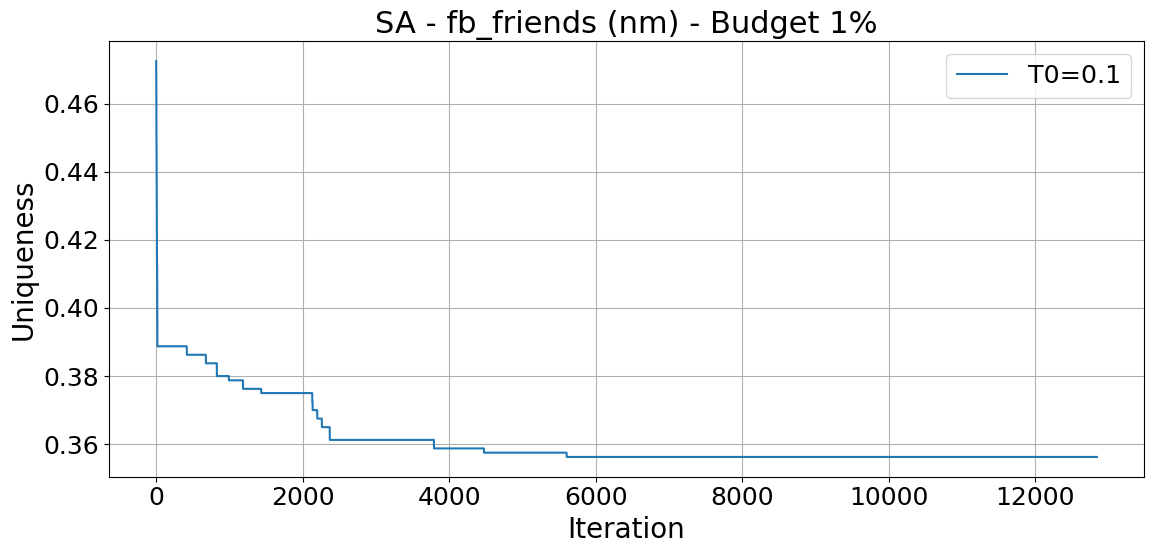

In [102]:
alphas = [0.8]
# temperatures = [0.01, 0.1, 1.0, 10.0, 100.0]
temperatures = [0.1]

method = "SA"  
document = "fb_friends"  
budgetDelete = 1 
criteria = "nm"  
STEP = 10  

plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 30,
    'figure.titlesize': 24,
})
for temp in temperatures:
    file_path = './intermediate results/{}_{}-{}-{}-{}-{}-STEP.txt'.format(
        method, document, budgetDelete, criteria, temp, STEP
    )
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            u = pickle.load(f)
            label = f'T0={temp}'
            plt.plot(range(len(u)), u, label=label)
    else:
        print(f"File not found: {file_path}")

plt.title(f"SA - {document} ({criteria}) - Budget {budgetDelete}%")
plt.xlabel("Iteration")
plt.ylabel("Uniqueness")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

#### The piece of code below is for running and saving all results on four budgets for the dataset selected in the beginning of the notebook.

In [ ]:
budgets = [1, 3, 5, 10]

for budgetDelete in budgets:
    u_ua, t_ua= experiment('UA', budgetDelete, criteria)
    u_gnm, t_gnm = experiment('(n,m)-Greedy',budgetDelete, criteria)
    u_lr, t_lr= experiment('LR', budgetDelete, criteria)
    u_SA, t_SA = experiment("SA", budgetDelete, criteria, T0=0.1, alpha=0.75)
    print("========================================", flush=True)
    print(flush=True)


./intermediate results/{}_{}-{}-{}-{}-STEP.txt'.format(method, document, budgetDelete, criteria, STEP
Results of UA
Final Uniqueness: 0.4135; Initial Uniqueness: 0.4725
Execution Time: 0.2956587314605713
Budget for edge deletions: 1
Final ACC: 0.31339613342547734
Final Transitivity: 0.2398065130823541
Final Number of Edges: 6369


KeyboardInterrupt: 

#### Plot and save all existing datasets

In [ ]:
datasets = ["fb_friends"]
# datasets = ["CollegeMsg", "CA-GrQc", "facebook_combined", "fb-pages-food", "soc-hamsterster", "fb_friends", "sms"] 
# budgets = [1, 3, 5, 10]
# datasets = ["CollegeMsg", "CA-GrQc", "facebook_combined", "fb-pages-food", "soc-hamsterster", "fb_friends", "sms"] 
budgets = [1, 3, 5, 10]
methods = ["UA", "(n,m)-Greedy", "LR", "SA"]
criteria = 'dk'
# Set global font size for clarity
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 22,
})

os.makedirs("plots", exist_ok=True)

for document in datasets:
    for budgetDelete in budgets:
        u_dict = {}
        for method in methods:
            filename = f"./intermediate results/{method}_{document}-{budgetDelete}-{criteria}-{10}STEP.txt"
            if not os.path.exists(filename):
                print(f"[MISSING] {filename}")
                continue
            with open(filename, "rb") as f:
                u_dict[method] = pickle.load(f)

        if len(u_dict) < len(methods):
            continue  # Skip if any method missing

        # Interpolation for SA to match CALCULATE_TIME
        u_SA = u_dict["SA"]
        CALCULATE_TIME=len(u_dict["LR"])  # Assuming u["SA"] is the list of uniqueness values for SA


        if len(u_SA) < CALCULATE_TIME:
            print(f"[WARNING] SA has fewer than {CALCULATE_TIME} iterations ({len(u_SA)})")
            continue
        else:
            # Uniformly sample CALCULATE_TIME values from SA's trajectory
            idxs = np.linspace(0, len(u_SA) - 1, CALCULATE_TIME).astype(int)
            u_SA_interp = [u_SA[i] for i in idxs]

        u_lr = u_dict["LR"]
        u_ua = u_dict["UA"]
        u_gnm = u_dict["(n,m)-Greedy"]

        x_vals = np.arange(CALCULATE_TIME)
        print(len(u_dict["SA"]))
        print(len(u_lr), len(u_ua), len(u_gnm), len(u_SA_interp))
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, u_ua, marker='s', linestyle='--', color='green', linewidth=2, markersize=6, label='UA')
        plt.plot(x_vals, u_lr, marker='o', linestyle='-', color='orange', linewidth=2, markersize=6, label='Logistic Regression')
        plt.plot(x_vals, u_gnm, marker='^', linestyle='-.', color='purple', linewidth=2, markersize=6, label='Greedy')
        plt.plot(x_vals, u_SA_interp, marker='v', linestyle='-', color='steelblue', linewidth=2, markersize=6, label='Simulated Annealing')

        plt.title(f"{document} ({criteria}) - Budget {budgetDelete}%")
        plt.xlabel("Iteration")
        plt.ylabel("Uniqueness")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/{document}_{budgetDelete}_{criteria}.png")
        plt.close()


1927
7 7 7 7
5785
20 20 20 20
9643
33 33 33 33
19288
65 65 65 65
